In [2]:
%load_ext autoreload
%autoreload 2
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"


import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch

import neural_metric
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
import numpy as np
import torch.nn.functional as F
import main_eval 
import default_config

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend


# Evaluate Synthetic Data

### From analytic form of immersion

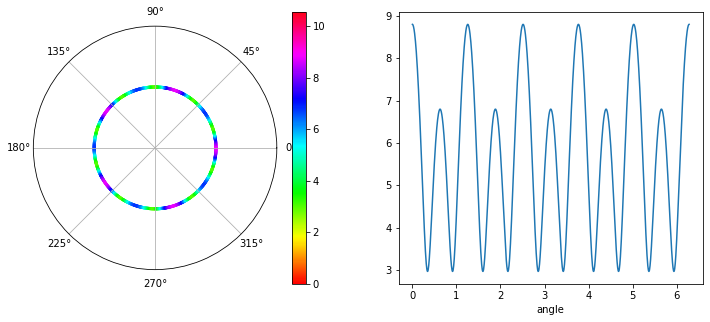

In [3]:
rot = SpecialOrthogonal(n=5).random_point()



params = {
    "immersion_type": "analytic",
    "radius": 1,
    "n_wiggles": 5,
    "amp_wiggles": 0.3,
    "embedding_dim": 5,
    "model_filename": None,
    "rot": rot
}

angles = gs.linspace(0,2*gs.pi,1000)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)

### From learned immersion via VAE

In [49]:
# results_prefix = ""


#model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-08-31 21:10:00_model.pt"

# model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-06 13:56:00_model.pt"
# # #model_filename = f"results/trained_models/{results_prefix}_model.pt"

# model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-06 16:42:00_model.pt"

# model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-06 17:03:00_model.pt"

model_filename = "/Users/franciscoacosta/Desktop/code/abn/abn/results/trained_models/wiggles_2022-09-06 17:15:00_model.pt"
model2 = torch.load(model_filename)


# from models.spherical_vae import SphericalVAE
# model1 = SphericalVAE(input_dim=6,
#                      encoder_dims=[40,40,40,40,40],
#                      latent_dim=2,
#                      distribution="vmf")

# model1.load_state_dict(torch.load("/Users/franciscoacosta/Desktop/code/abn/abn/results/modelsd.pt"))

# model1.eval()

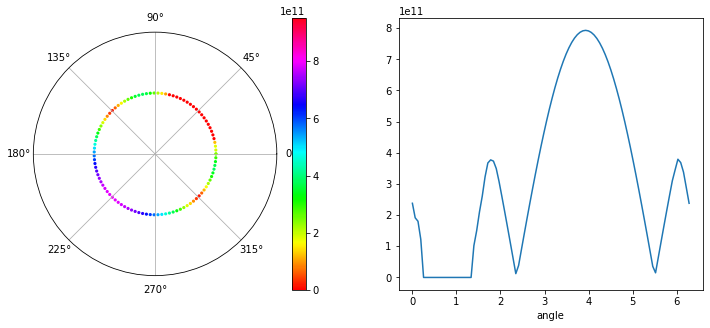

In [50]:
params = {
    "immersion_type": "VAE",
    "radius": None,
    "n_wiggles": None,
    "amp_wiggles": None,
    "embedding_dim": default_config.embedding_dim,
    "model": model2,
}

angles = gs.linspace(0,2*gs.pi,100)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)

In [24]:
gen_likelihood_params_batch, posterior_params = model2()

NameError: name 'dataset' is not defined

In [18]:

from datasets import utils
dataset_torch, labels, train_loader, test_loader = datasets.utils.load(default_config)

Dataset shape: torch.Size([1000, 2]).


/Users/franciscoacosta/Desktop/code/abn/abn/datasets/synthetic.py:247: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gs.stack([gs.cos(angle), gs.sin(angle)], axis=0))
/Users/franciscoacosta/Desktop/code/abn/abn/datasets/synthetic.py:252: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "ik,jk->ij", polar(angles), torch.diag(torch.tensor(amplitudes))
/Users/franciscoacosta/Desktop/code/abn/abn/datasets/synthetic.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wiggly_circle = torch.tensor(wiggly_circle)
/Users/francis

In [22]:
x = [train_loader.dataset[i][0][0] for i in range(700)]
y = [train_loader.dataset[i][0][1] for i in range(700)]

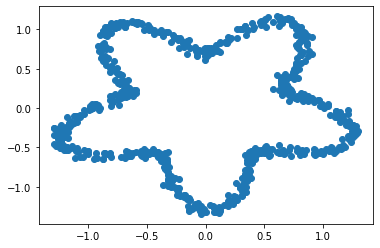

In [23]:
plt.scatter(x,y)

In [31]:
thetas = torch.linspace(0,2*torch.pi,100)
z = torch.stack([torch.cos(thetas), torch.sin(thetas)],axis=-1)

In [32]:
z.shape

torch.Size([100, 2])

In [51]:
a = model2.decode(z)

-27703136000.0

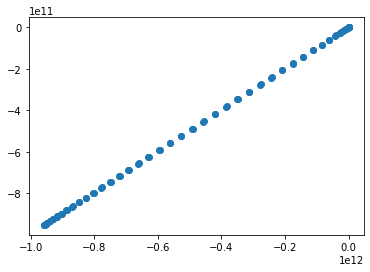

In [52]:
a[0].shape

x = a[0][:,0].cpu().detach().numpy()
y = a[0][:,1].cpu().detach().numpy()

plt.scatter(x,y)

x[0]

In [24]:
immersion1 = neural_metric.get_neural_immersion(model1)

In [51]:
immersion2 = neural_metric.get_neural_immersion(model2)

In [54]:
theta = torch.tensor(torch.pi/3)

func = lambda x: immersion2(x)[0]

g = torch.autograd.functional.hessian(func,inputs=theta, strict=True)

In [55]:
g

tensor(0.3034)

In [28]:
immersion1(theta)

tensor(2.0479, grad_fn=<UnbindBackward0>)

In [52]:
immersion2(theta)

tensor([-0.7135, -0.0035, -1.9717, -1.8315, -1.1628], grad_fn=<AddBackward0>)

In [30]:
def get_immersion(model):
    def imm(theta):
        z = torch.tensor([torch.cos(theta), torch.sin(theta)])
        x_rec = model.decode(z)
        return x_rec
    return imm

In [42]:
immersion1 = get_immersion(model1)

In [43]:
immersion1(theta)

tensor([-0.5145, -0.2627, -1.0943,  0.3953,  0.2808, -0.9181],
       grad_fn=<AddBackward0>)

In [37]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point, strict=True
        )
    return H

In [53]:
H1 = mean_curv(theta,immersion2, 2)

In [39]:
H2 = mean_curv(theta, immersion2, 5)

In [40]:
H2

tensor([-0.0118,  0.0263,  0.0093, -0.0090,  0.0040])